# Example of MCMC run

In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using BenchmarkTools

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using DSP

In [3]:
# using Revise
using BAT 

# Load Data

In [4]:
function trunc_norm(m, sgm; alpha=2)
    return truncated(Normal(m, sgm), m - alpha*sgm, m + alpha*sgm)
end

trunc_norm (generic function with 1 method)

## 1.1 Low `p` Population: 

In [5]:
conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
)

images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
event_number = 9

# Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

## 1.2 High `p` Population: 

In [ ]:
# conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

# conv_matrices = (
#     cam_1 = conv_mat["cam_1"],
#     cam_2 = conv_mat["cam_2"],
#     cam_3 = conv_mat["cam_3"],
#     cam_4 = conv_mat["cam_4"], 
# ) 

# images = load("../data/experiment/dataset_2/m2/images-satur.jld2"); # removed saturated pixels
# # images = load("../data/experiment/dataset_2/m2/images.jld2"); # included saturated pixels
# event_number = 2

# # Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

# event = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_4"][event_number,:,:],
#     population = images["charge"][event_number,:][1],
# );


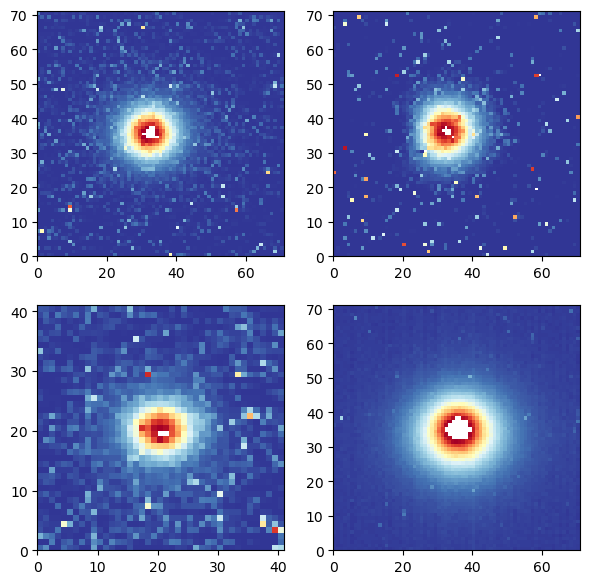

PyObject <matplotlib.collections.QuadMesh object at 0x7f9e4ab99cd0>

In [6]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

# Load Model

## Model 35: 

In [ ]:
# include("../src/model-35/likelihood.jl")
# include("../src/model-35/utill_model.jl")
# include("../src/utill.jl")

In [ ]:
# β1= 0.015
# β2 = 0.0077
# β3 = 0.0058

# # # flat prior for the pixel size
# # prior = NamedTupleDist(
# #         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
# #         ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)],
# #         waist = [Normal(2.9, 0.03)],
# #         algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
# #         algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
# #         cam4_ped = 4.0 .. 40.0,
# #         cam4_light_fluct = 1.0 .. 3.0,
# #         cam4_light_amp = 1.6 .. 9.9, 
# #         resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
# #         resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
# #         cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
# #         cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
# #         psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
# #         psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
# #         cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
# #         cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
# #         light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
# #         s_cam = [0.0, 1.478, 15.026, 23.1150],
# #     ); 

## Model 38: 

In [ ]:
# include("../src/model-38/likelihood.jl")
# include("../src/model-38/utill_model.jl")
# include("../src/utill.jl")

In [ ]:
# β1= 0.015
# β2 = 0.0077
# β3 = 0.0058 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 23, 24, 25, 
#     resy = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 26,27, 28, 
#     cam4_resx = trunc_norm(3, 1.5), # 29, 
#     cam4_resy = trunc_norm(3, 1.5), # 30
#     psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
#     psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
#     cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
#     cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.20), truncated(Normal(0.2, 0.04), 0.06, 0.20)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 2.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [1, 1, 1], # 23, 24, 25, 
#     resy = [1, 1, 1], # 26,27, 28, 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
#     psx = [27.1, 21.6, 114.0], # 31, 32, 33
#     psy = [30.5, 23.4, 125.0], # 34, 35, 36
#     cam4_psx = 121.8, # 37
#     cam4_psy = 120.0, # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

## Model 41: 

In [7]:
include("../src/model-41/likelihood.jl")
include("../src/model-41/utill_model.jl")
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [ ]:
# β1 = 0.015
# β2 = 0.0077
# β3 = 0.0058 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.035, 0.25), truncated(Normal(0.2, 0.04), 0.035, 0.25)],
#     tr_size_2 = [truncated(Normal(0.2, 0.04), 0.035, 0.25), truncated(Normal(0.2, 0.04), 0.035, 0.25)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.3)], # 11
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], # 23, 24, 25, 
#     resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], # 26,27, 28, 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf), # 29, 
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf), # 30
#     psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # 31, 32, 33
#     psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)], # 34, 35, 36
#     cam4_psx = truncated(Normal(121.8, 121.8*β3), 0., Inf), # 37
#     cam4_psy = truncated(Normal(120.0, 120.0*β3), 0., Inf), # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

In [8]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#     tr_size_2 = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.3)], # 11
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 23, 24, 25, 
#     resy = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 26,27, 28, 
#     cam4_resx = trunc_norm(3, 1.5), # 29, 
#     cam4_resy = trunc_norm(3, 1.5), # 30
#     psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
#     psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
#     cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
#     cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.16), truncated(Normal(0.2, 0.04), 0.03, 0.16)],
#     tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.16), truncated(Normal(0.2, 0.04), 0.03, 0.16)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
#     waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 2.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [1, 1, 1], # 23, 24, 25, 
#     resy = [1, 1, 1], # 26,27, 28, 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
#     psx = [27.1, 21.6, 114.0], # 31, 32, 33
#     psy = [30.5, 23.4, 125.0], # 34, 35, 36
#     cam4_psx = 121.8, # 37
#     cam4_psy = 120.0, # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ; # used in sampling

prior = NamedTupleDist(
    tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.16), truncated(Normal(0.2, 0.04), 0.03, 0.16)],
    tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.16), truncated(Normal(0.2, 0.04), 0.03, 0.16)],
    ang_spr = [truncated(Normal(4.0, 2.0), 4.5, 7.0), truncated(Normal(4.0, 2.0), 4.5, 7.5)],
    ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
    mixt_pow =  0.52 .. 1.0 ,
    waist = [truncated(Normal(2.9, 0.03), 3.0, 3.5)],
    waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.0)], # 11
    algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    cam4_ped = 4.0 .. 40.0,
    cam4_light_fluct =  1.0 .. 3.0,
    cam4_light_amp = 1.6 .. 9.9, 
    resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
    resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
    cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
    cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
    psx = [27.1, 21.6, 114.0], # 31, 32, 33
    psy = [30.5, 23.4, 125.0], # 34, 35, 36
    cam4_psx = 121.8, # 37
    cam4_psy = 120.0, # 38
    light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
    s_cam = [0.0, 1.478, 15.026, 23.1150],
);

# MCMC settings: 

In [9]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_discrete,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

function log_lik_diff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_cont,
    cv_1 = exp.(cv_mat.cam_1),
    cv_2 = exp.(cv_mat.cam_2),
    cv_3 = exp.(cv_mat.cam_3),
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        
        return LogDVal(ll)
    end
    
end

# log_likelihood = log_lik_diff()

log_likelihood = log_lik_ndiff()

#52 (generic function with 1 method)

In [11]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCChainPoolInit(
    init_tries_per_chain = ClosedInterval(50,150),
    max_nsamples_init = 500,
    max_nsteps_init = 500,
    max_time_init = Inf
)

burnin = MCMCMultiCycleBurnin(
    max_nsamples_per_cycle = 10000,
    max_nsteps_per_cycle = 10000,
    max_time_per_cycle = Inf,
    max_ncycles = 130
)

nsamples = 4*10^5
nchains = 4

sampler = MetropolisHastings(tuning=tuning,)

algorithm = MCMCSampling(sampler=sampler, 
    nchains=nchains, 
    init=init, 
    burnin=burnin, 
    convergence=convergence
);

In [ ]:
# log_likelihood(param_truth)
# @benchmark log_likelihood(param_truth)

In [12]:
@time samples_tot = bat_sample(
    posterior, nchains*nsamples, algorithm,
    max_neval = nchains*nsamples,
    max_time = Inf,
);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 4 fini

1118.616962 seconds (3.11 G allocations: 2.712 TiB, 14.23% gc time)


In [13]:
samples = samples_tot.result;

In [14]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

270.4383218923952

In [15]:
size(flatview(unshaped.(samples.v)))

(33, 352008)

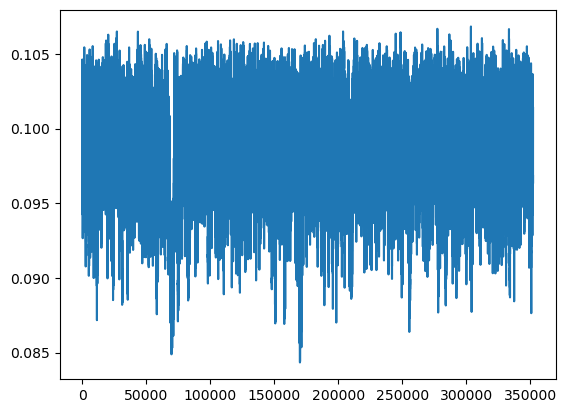

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9e2449fd00>

In [16]:
plot(flatview(unshaped.(samples.v))[3,:])

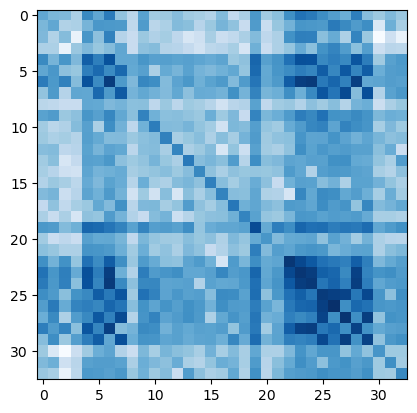

PyObject <matplotlib.image.AxesImage object at 0x7f9e24487040>

In [17]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [18]:
# BAT.bat_write("../data/sampling_results/Tmp-Mixture-Model-38-2/mm-38-hc-2-fixed-lf.hdf5", unshaped.(samples))

# BAT.bat_write("../data/sampling_results/To_delete_2/new_cv-nontr.hdf5", unshaped.(samples))

In [19]:
#  27.1, 21.6, 114.0, 30.5, 23.4, 125.0, 121.8, 120.0

In [20]:
mode(samples)[1]

(tr_size = [0.07267896568937227, 0.05255835361613483], tr_size_2 = [0.10283336768395603, 0.10149105931129417], ang_spr = [5.465558819732698, 6.643564320519931], ang_spr_2 = [1.0770404765817922, 2.8141250071708965], mixt_pow = 0.5211820226666479, waist = [3.122264886066275], waist_2 = [2.880021484333147], algmx = [35.88792688452945, 36.40489653546103, 20.12029003066304, 34.37737983328031], algmy = [32.50479932977972, 33.003851448004674, 20.652371737750627, 36.31182600749055], cam4_ped = 19.028577158189993, cam4_light_fluct = 1.2384600680652393, cam4_light_amp = 2.7213836682806223, resx = [0.7481467508389887, 1.7522054796211672, 1.9026970519488264], resy = [1.2795716943689754, 0.6833017423799163, 0.47988534840532043], cam4_resx = 5.251647185304908, cam4_resy = 3.4036213137725344, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [2.92409367130347, 3.842887444029371, 2.4697183220917376], s_cam = [0.0, 1.478, 15.026, 23.115])

In [21]:
bat_marginalmode(samples).result

ShapedAsNT((tr_size = [0.06975, 0.0537], tr_size_2 = [0.1007, 0.10305], ang_spr = [5.532500000000001, 6.657500000000001], ang_spr_2 = [1.2650000000000001, 2.7925], mixt_pow = 0.5201, waist = [3.1345], waist_2 = [2.865], algmx = [35.8525, 36.4035, 20.137, 34.3815], algmy = [32.492999999999995, 33.0035, 20.649, 36.316500000000005], cam4_ped = 18.985, cam4_light_fluct = 1.24875, cam4_light_amp = 2.7272499999999997, resx = [0.485, 1.915, 1.8450000000000002], resy = [1.1749999999999998, 0.755, 0.545], cam4_resx = 5.1850000000000005, cam4_resy = 3.425, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [2.9335, 3.8715, 2.4405], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [22]:
mean(samples)[1]

(tr_size = [0.0682866909200585, 0.05128609165917665], tr_size_2 = [0.09879133340166682, 0.10213350635050758], ang_spr = [5.563831040030586, 6.643511334060206], ang_spr_2 = [1.3789217857786358, 2.751884165121188], mixt_pow = 0.5230223272434111, waist = [3.132984898002185], waist_2 = [2.8609493333852907], algmx = [35.85133652245611, 36.399825267322264, 20.127781472525832, 34.38198382644669], algmy = [32.49106302459025, 33.00898515849347, 20.651219494755477, 36.31566096227107], cam4_ped = 18.965409907876968, cam4_light_fluct = 1.2502262572831713, cam4_light_amp = 2.7252103710823183, resx = [0.5155512055645162, 1.9465650097645841, 1.6070785894515909], resy = [1.1782916796034493, 0.7322200659995777, 0.5734125043062845], cam4_resx = 5.0120115817105315, cam4_resy = 3.505840784076367, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [2.934413129150662, 3.8742155333052786, 2.4404033423879423], s_cam = [0.0, 1.478, 15.026, 23.115])

In [23]:
std(samples)[1]

(tr_size = [0.007339496587313746, 0.0071899458380184226], tr_size_2 = [0.0033737043448065643, 0.0021350636679567684], ang_spr = [0.08099577671932268, 0.05485294849060191], ang_spr_2 = [0.25122389616424606, 0.09330658521514153], mixt_pow = 0.00280802409642262, waist = [0.025553075559369157], waist_2 = [0.029404869620171956], algmx = [0.02600430899687523, 0.022933671340281278, 0.03341075866944637, 0.02143469099963215], algmy = [0.026668237182285264, 0.02417913081397885, 0.03649962016975364, 0.023333691252278684], cam4_ped = 0.14849307807582046, cam4_light_fluct = 0.012978116082300846, cam4_light_amp = 0.00980880579519207, resx = [0.282664133962771, 0.3079288807635896, 0.28741452455723526], resy = [0.25133882817469605, 0.3672539494329702, 0.3092915847681391], cam4_resx = 0.2034396620241577, cam4_resy = 0.19948866815781, psx = 3-element Fill{Float64}: entries equal to 0.0, psy = 3-element Fill{Float64}: entries equal to 0.0, cam4_psx = 0.0, cam4_psy = 0.0, light_amp = [0.013636360139879134

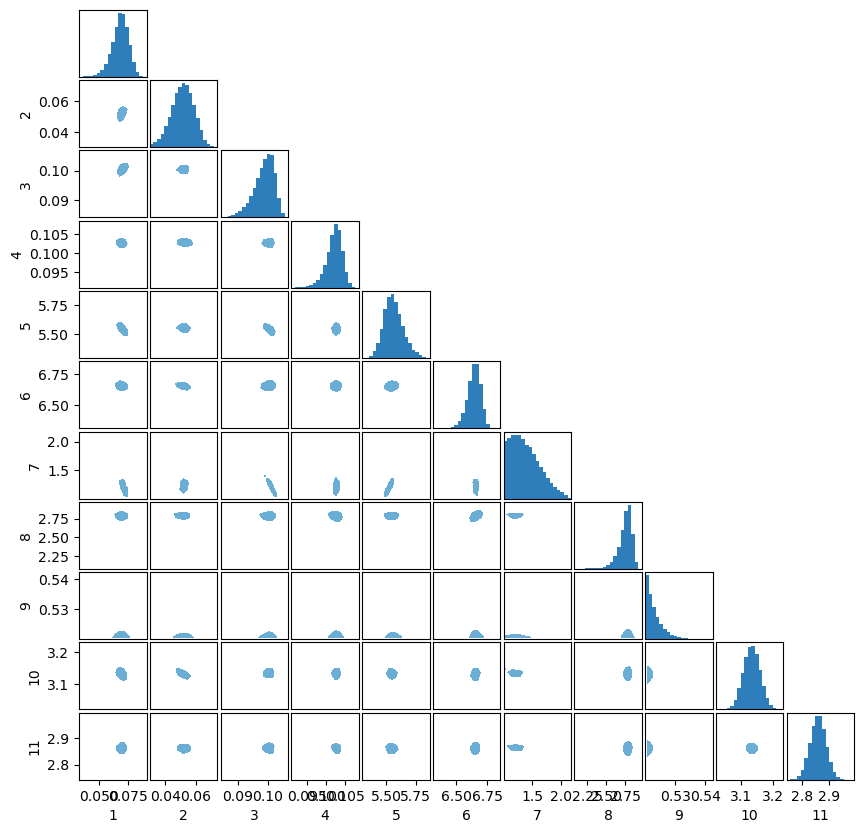

In [24]:
dims = [1,2,3,4,5,6,7,8,9,10,11]
# dims = [1,2,3,4,5,]
names = [1,2,3,4,5,6,7,8,9,10, 11]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

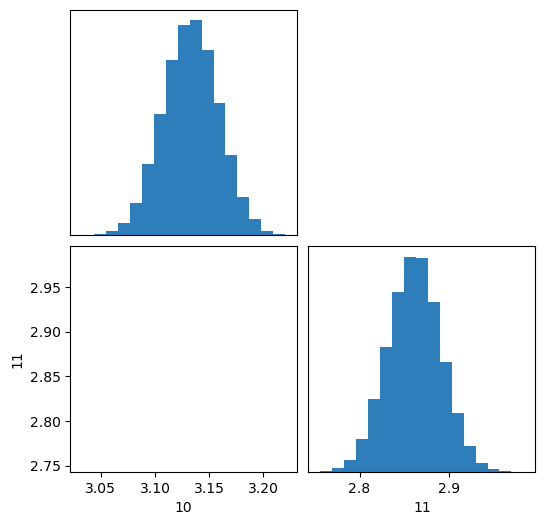

In [25]:
dims = [10,11,]
names = [10,11,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.1,  1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

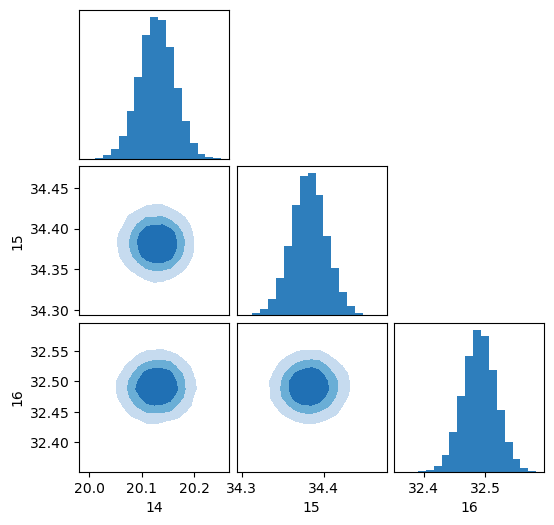

In [26]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

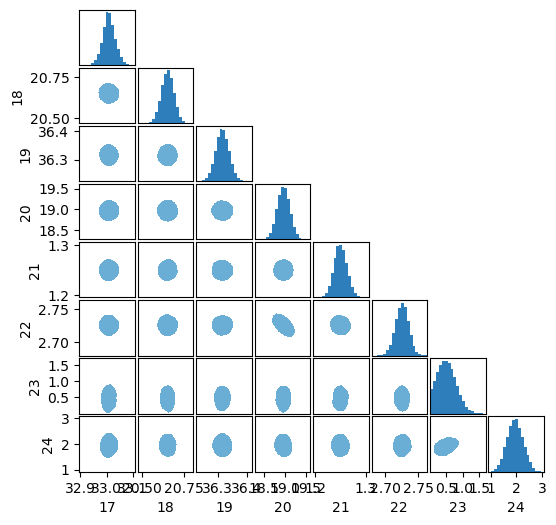

In [27]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

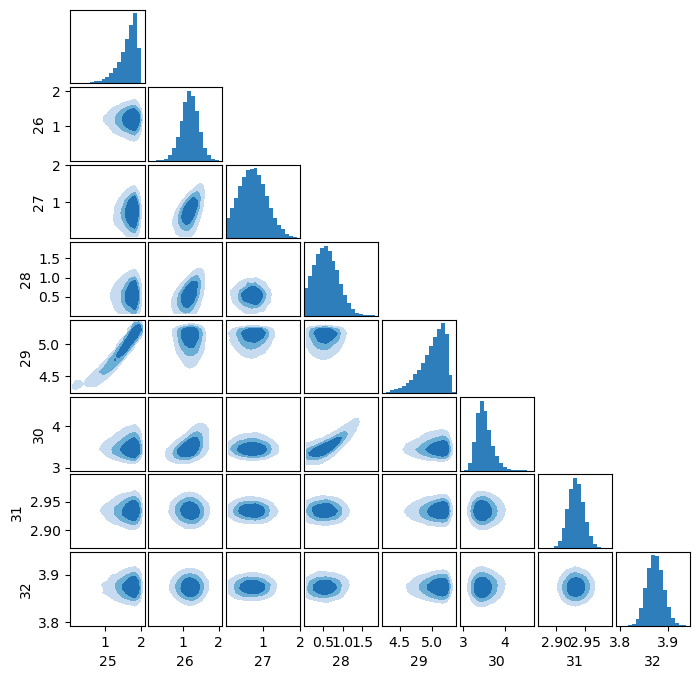

In [28]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [29]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 33×352008 ElasticArrays.ElasticArray{Float64,2,1,Array{Float64,1}} at index [34, 1:352008]

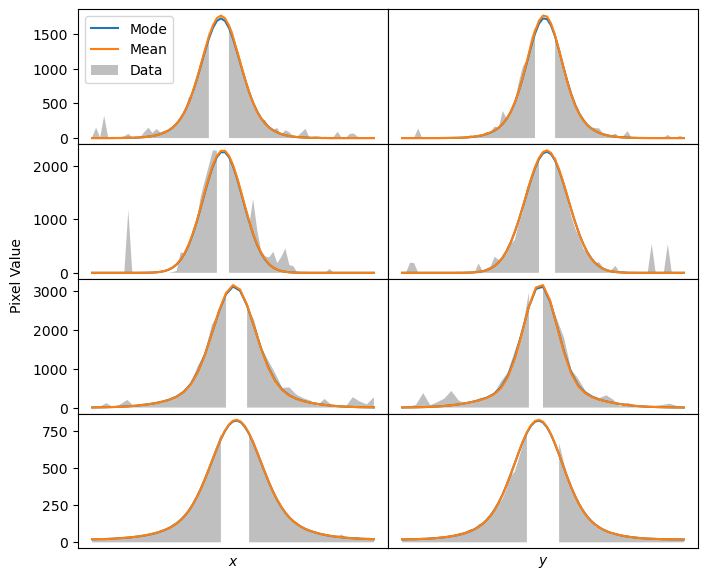

PyObject Text(0.04, 0.5, 'Pixel Value')

In [30]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

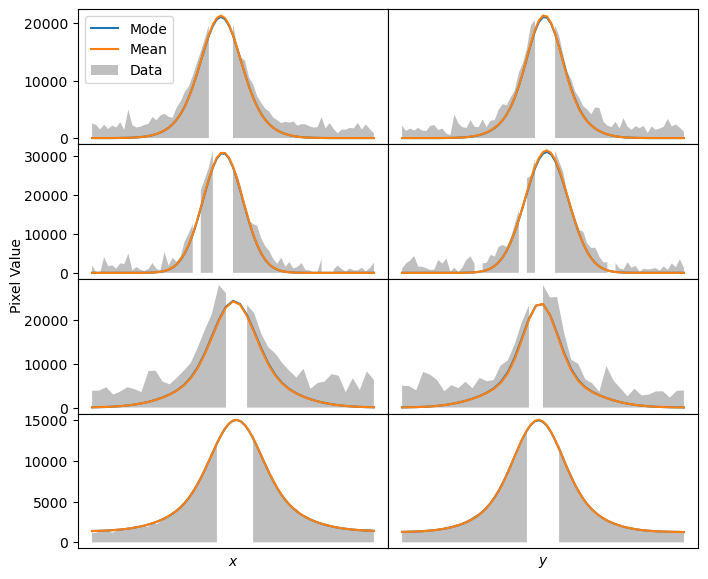

PyObject Text(0.04, 0.5, 'Pixel Value')

In [31]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

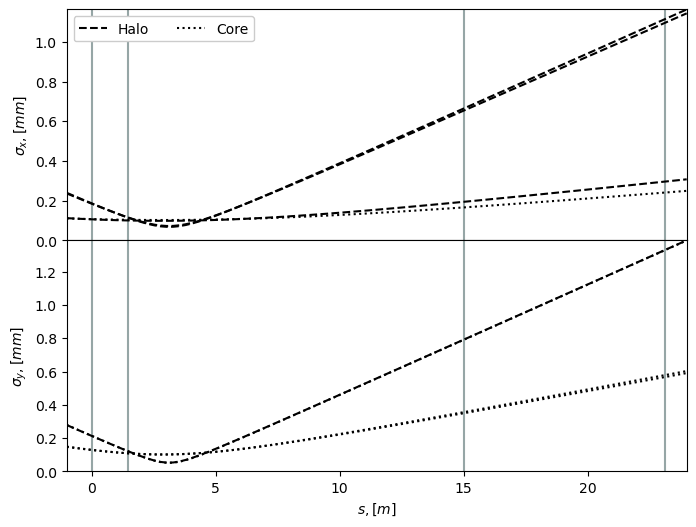

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [32]:
params_array = [mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [33]:
images = load("../data/experiment/dataset_2/m1/images.jld2")
event_ns = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

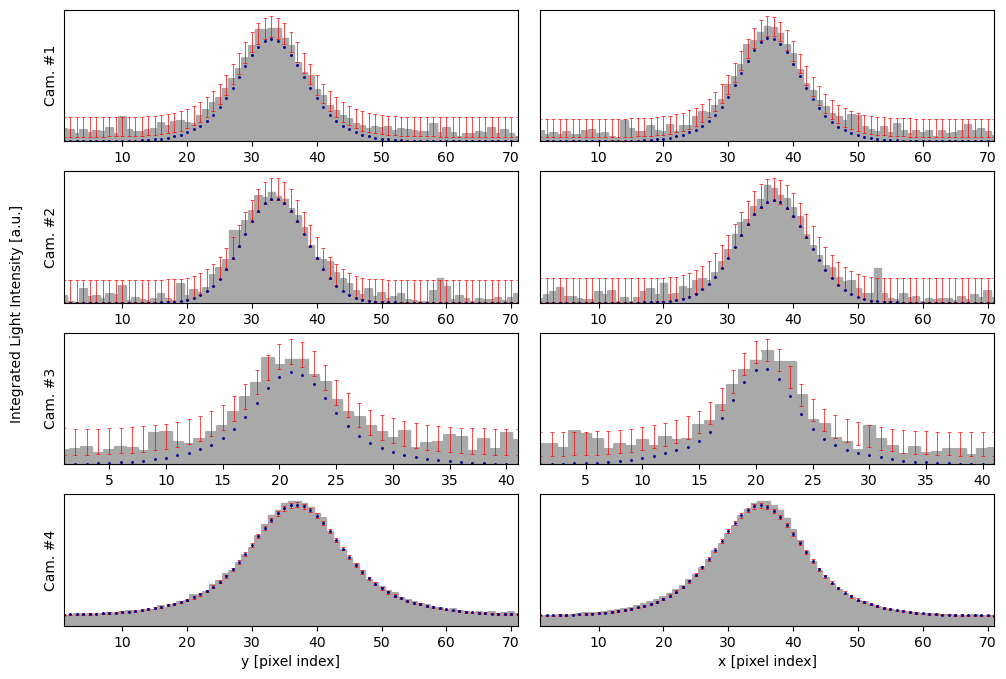

PyObject Text(0.08, 0.5, 'Integrated Light Intensity [a.u.]')

In [34]:
plot_projections(conv_matrices, event_ns, event, params_array[1], isnontr = true)

In [35]:
# try model 38 with light fluctuations constant on the IS2
# fixe resolution in the IS2 amera